# Results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", None)

### Useful Functions

In [2]:
def plot_training_log(log, acc=True, loss=True, lr=True, figsize=(10.0, 3.0)):
    plt.rcParams['figure.figsize'] = figsize
    i = log['val_acc'].idxmax() + 1
    
    if acc:
        plt.axvline(x=i, color='0.5', linestyle='--')
        plt.plot(log['epoch'], log['acc'], label='Train')
        plt.plot(log['epoch'], log['val_acc'], label='Validation')
        plt.minorticks_on()
        plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xlim(0, log['epoch'].iloc[-1] + 1)
        #plt.ylim(0.9, 1.0)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    if loss:
        plt.axvline(x=i, color='0.5', linestyle='--')
        plt.plot(log['epoch'], log['loss'], label='Train')
        plt.plot(log['epoch'], log['val_loss'], label='Validation')
        plt.minorticks_on()
        plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xlim(0, log['epoch'].iloc[-1] + 1)
        #plt.ylim(0.9, 1.0)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    if lr and 'lr' in log.columns:
        fig, ax1 = plt.subplots()
        plt.axvline(x=i, color='0.5', linestyle='--')

        ln1 = ax1.plot(log['epoch'], log['lr'], 'C4o-', label='Learning Rate')   
        ax1.set_xticks(log['epoch'], minor=True)
        ax1.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Learning Rate')
        ax1.set_xlim(0, log['epoch'].iloc[-1] + 1)

        ax2 = ax1.twinx()
        ln2 = ax2.plot(log['epoch'], log['val_acc'], 'C1o-', 
                       label='Validation Accuracy [0.98 - 1.0]')        
        #ax2.set_ylabel('Val Accuracy')
        ax2.set_yticks([])
        ax2.set_ylim(0.98, 1.0)        

        lns = ln1 + ln2        
        plt.legend(lns, [l.get_label() for l in lns])
        plt.tight_layout()
        plt.show()
        
        
def plot_log_for(results, idx=-1, acc=True, loss=True, lr=True, figsize=(10.0, 3.0)):   
    filename = results.iloc[idx]['log']
    if type(filename) != str:
        print('Log not available')
        return
    log = pd.read_csv('logs/' + filename)
    log['epoch'] += 1
    display(results.loc[[idx]].drop(['epochs', 'log'], axis=1))
    plot_training_log(log, acc=acc, loss=loss, lr=lr, figsize=figsize)
    return idx, log
    
    
def plot_annealers(annealers, epochs=40, figsize=(10.0, 3.0)):
    plt.rcParams['figure.figsize'] = figsize
    x = np.arange(0, epochs)
    for k, v in annealers.items():
        plt.plot(x + 1, v(x), label=k)
    plt.minorticks_on()
    plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
    plt.grid(b=True, axis='y', which='major', color='0.8', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.xlim(0, epochs + 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
def reduce_on_plat(lr, factor, plats, epochs):
    y = []
    for e in range(epochs):
        if e in plats:
            lr *= factor
        y.append(lr)
    return y

### Exploratory Analysis

In [3]:
results = pd.read_csv('results.csv')
results['notes'].fillna('', inplace=True)

In [20]:
rfilter = (results['optimizer'].str.contains('SGD')) & (results['annealer'].str.contains('Linear')) # & (results['log'].notna())
sort_by = ['val_acc', 'epoch', 'optimizer args']
sort_ascending = [0,1,1]

results[rfilter].drop('log', axis=1).sort_values(by=sort_by, ascending=sort_ascending)

,val_acc,val_loss,lr,epoch,optimizer,optimizer args,annealer,annealer args,dropout type,dropout rates,notes,batch size,epochs,keras,tf
16,0.9945,NaN,0.0413,16,SGD,"(lr=0.066, momentum=0.95)",LinearDecay,NaN,spatial,"(0,0,.3,.5)",,64,40,2.1.5,1.4.1


,val_acc,val_loss,lr,epoch,optimizer,optimizer args,annealer,annealer args,dropout type,dropout rates,notes,batch size,keras,tf
44,0.995,0.0251,0.015,25,SGD,"(lr=0.06, momentum=0.96, nesterov=False)",ReduceLROnPlateau,"(monitor='val_loss', factor=0.5, patience=4, min_lr=0.001, verbose=1)",spatial,"(0,0,.3,.5)",,64,2.2.2,1.10.0


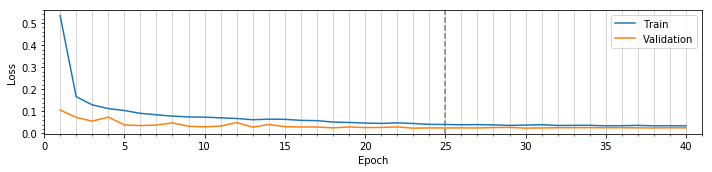

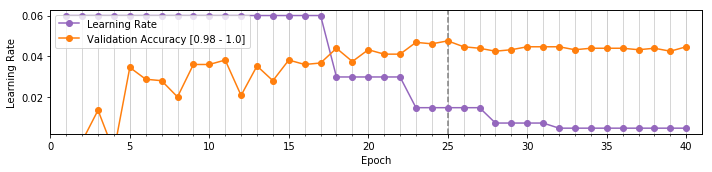

,val_acc,val_loss,lr,epoch,optimizer,optimizer args,annealer,annealer args,dropout type,dropout rates,notes,batch size,keras,tf
34,0.9948,0.024,0.033,29,SGD,"(lr=0.066, momentum=0.96, nesterov=False)",ReduceLROnPlateau,"(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0002, verbose=1)",spatial,"(0,0,.3,.5)",padding='same' in stem,64,2.1.5,1.4.1


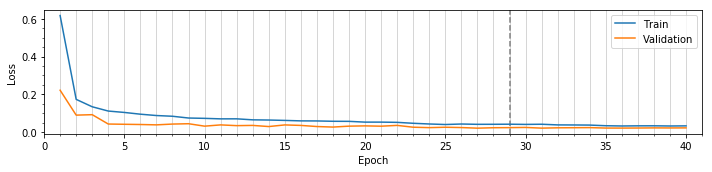

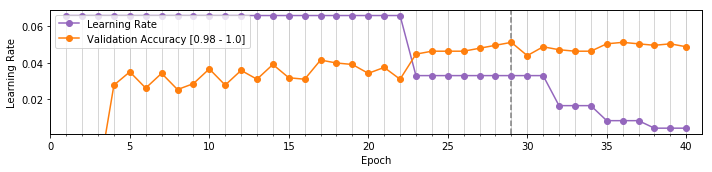

In [9]:
log = plot_log_for(results, idx=44, loss=True, acc=False, figsize=(10.0, 2.5));
plot_log_for(results, idx=34, loss=True, acc=False, figsize=(10.0, 2.5));

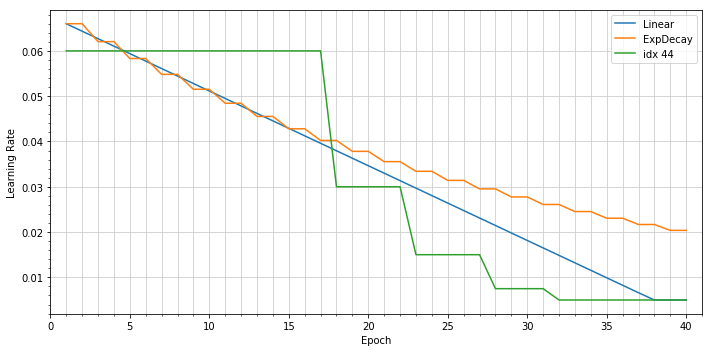

In [26]:
annealers = {}
epochs = 40

#annealers['Linear'] = lambda x, lr=0.066: lr * (1 - x / epochs)

annealers['Linear'] = lambda x, lr=0.066, end_lr=0.000, min_lr=0.005: \
    np.maximum(lr - (lr - end_lr) / epochs * x, min_lr)
    
annealers['ExpDecay'] = lambda x, lr=0.066, rate=0.94, min_lr=0.0001: \
    np.maximum(lr * rate**(x//2), min_lr)
    
#annealers['Custom'] = lambda x, start=0.04, end=0.005, center=24: \
#    (start - end) / (1 + np.e**((x - center) / 3)) + end
    
#annealers['ReduceOnPlateau'] = lambda x: reduce_on_plat(lr=0.04, factor=0.5, plats=[19, 27, 32], epochs=40)

annealers['idx ' + str(log[0])] = lambda x: log[1]['lr']

#annealers['Constant'] = lambda x: np.repeat(0.001, len(x))

plot_annealers(annealers, epochs=epochs, figsize=(10.0, 5.0))

## Notes

Best so far: 9957 - loss 0.0195, Adam with linear decay, 120 epochs, peak at roughly epoch 70, batch dropout(.2,.2,.2,.3)

If data augs not listed in notes then they're:

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=15,
    zoom_range=[0.9, 1]
    
- Good ReduceOnPlat points from Desmos: (0,0.04),(18,0.04),(19,0.02),(26,0.02),(27,0.01),(31,0.01),(32,0.005),(34,0.005)

- 64 didn't increase accuracy over 32, in stem
- second conv layer in stem doesn't increase accuracy
- same' padding leads to overfitting with drop out (.2,.2,.2,.3), and validation accuracy stalls with (.3,.3,.3,.5) - also repeats in weights visualizations
- 3,3 max pool hit .9952 with dropout (.2,.2,.2,.2)
- no batch norm - less accuracy
- label smoothing - loss < .02, val acc 0.5
- he_uniform on all layers - vall_acc never got over .995 (got to .9948) , weight vis still looked like noise after 120 epochs
- PRelu (alpha=0.25) - extreme overfitting, increase drop out?
- he_uniform last layer, < 0.995
- droput that preserves inception topology overfits (.2, .2, .2, .3)
- label smoothing, dropout (.25,.25,.25,.25) overfits, < 0.995
- label smoothing, combined dropout (.2,.2,.2,.2)(.4) overfits, < 0.995
- dropout with noise shape seems to have weight vis that is less 'noisy' (might actually be from decreasing Adams learning rate too quickly)
- RMSprop(lr=0.045, rho=0.9, epsilon=1.0, clipvalue=2.0),  # incep v3 paper setting max out at .9940, weight vis still noisy after 100 epochs
- repeats in weight vis appears some what common with dropout only in last 2 modules

Label Smoothing:
- looks like it might stop validation loss from increasing when over training i.e. without label smoothing, there's a certain point where val loss stops decreasing and starts to trend upwards, with label smoothng there's no upward trend

Things to try:
- same padding with SGD


**old notes, results now stored in results.csv**

Best so far: 9957 - loss 0.0195, Adam with linear decay, 120 epochs, peak at roughly epoch 70, batch dropout(.2,.2,.2,.3)

SGD 9952 - learning rate 0.0378 at epoch 20 (decayed from 0.066, momentum=0.95, schedule decay rate 0.94), epoch 24 train loss increaseses by 0.003 before that any train loss increases were by < 0.002

if dropout isn't listed then it's (spatial dropout: 0,0,.3,.5)

if data augs not listed then they're:

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=15,
    zoom_range=[0.9, 1]

### SGD
- momentum = 0.97 hit 9943, lr 0.0330 at epoch 34 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)
---
- momentum = 0.96 hit 9950, lr 0.0165 at epoch 31 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)
- momentum = 0.96 hit 9940, lr 0.0168 at epoch 30 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.067)
- momentum = 0.96 hit 9936, lr 0.0165 at epoch 23 (reduce on plateau, factor=0.25, patience=3, initial lr = 0.066, no label smoothing)(spatial dropout: 0.2,0.2,0.2,0.3)
- momentum = 0.96 hit 9926, lr 0.0082 at epoch 16 (reduce on plateau, factor=0.5, patience=0, initial lr = 0.066, no label smoothing)(spatial dropout: 0.2,0.2,0.3,0.5)
- momentum = 0.96 hit 9945, lr 0.0041 at epoch 36 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)(spatial dropout: 0,0,.5,.5)
- momentum = 0.96 hit 9945, lr 0.0297 at epoch 23 (schedule decay, rate=0.93, initial lr = 0.066)
---
- momentum = 0.95 hit 9943, lr 0.0165 at epoch 28 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)
- momentum = 0.95 hit 9948 (loss=0.0171), lr 0.005 at epoch 34 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.04)
- momentum = 0.95 hit 9945 (overfit), lr 0.0200 at epoch 27 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.04)(no rotation or skew)
- momentum = 0.95 hit 9921, lr 0.0200 at epoch 31 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.04)(no rotation or skew)(spatial dropout: .5,.5,.5,.5)
- momentum = 0.95 hit 9926, lr 0.0165 at epoch 33 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)(no rotation or skew)(spatial dropout: 0,.5,.5,.5)
- momentum = 0.95 hit 9938, lr 0.0006 at epoch 29 (reduce on plateau, factor=0.5, patience=2, initial lr = 0.04)
- momentum = 0.95 dud, stalled at 9926 (reduce on plateau, factor=0.5, patience=0, initial lr = 0.04)
- momentum = 0.95 hit 9931, lr 0.0181 at epoch 20 (schedule decay, rate=0.92, initial lr = 0.04)
- momentum = 0.95 hit 9952, lr 0.0378 at epoch 20 (schedule decay, rate=0.94, initial lr = 0.066)
- momentum = 0.95 hit 9945, lr 0.0413 at epoch 16 (linear decay, epochs=40, initial lr = 0.066)
- momentum = 0.95 hit 9945, lr 0.0165 at epoch 28 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066, no label smoothing)
- momentum = 0.95 hit 9943, lr 0.0231 at epoch 35 (schedule decay, rate=0.94, initial lr = 0.066)(he_uniform on last 2 modules)
---
- momentum = 0.94 hit 9945, lr 0.0165 at epoch 25 (reduce on plateau, factor=0.5, patience=3, initial lr = 0.066)

### Adamax
- beta_1 = 0.5 hit 9950, lr 0.001 at epoch 32 (reduce on plateau, factor=0.5, patience=0, initial lr = 0.03, min_lr = 0.001)
- beta_1 = 0.5 hit 9945 (no overfit), lr 0.005 at epoch 30 (reduce on plateau, factor=0.9, patience=0, initial lr = 0.03, min_lr = 0.0005)(spatial dropout: .0,.0,.5,.5)
- beta_1 = 0.49 hit 9948, at epoch 34 (linear decay, initial lr = 0.01, 40 epochs, min_lr = 0.0002)
- beta_1 = 0.49 hit 9945 (overfit), at epoch 37 (linear decay, initial lr = 0.02, 40 epochs, min_lr = 0.0002)(batch dropout: .2,.2,.2,.3)
- beta_1 = 0.49 hit 9950 (overfit), lr 0.001 at epoch 18 (reduce on plateau, monitor='loss', factor=0.5, patience=0, initial lr = 0.04, min_lr = 0.0002)
- beta_1 = 0.49, beta_2 = 0.95, hit 9933, lr 0.005 at epoch 30 (reduce on plateau, monitor='val_loss', factor=0.5, patience=3, initial lr = 0.04, min_lr = 0.0002)
- beta_1 = 0.49 hit 9938, lr 0.01 at epoch 19 (reduce on plateau, monitor='loss', factor=0.5, patience=0, initial lr = 0.04, min_lr = 0.0002)(batch dropout: .5,.5,.5,.5)